In [353]:
import pandas as pd
import numpy as np
import sys
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
alt.data_transformers.disable_max_rows()
sys.path.append('../data')
%matplotlib inline

In [2]:
injury = pd.read_csv('data/InjuryRecord.csv')
player = pd.read_csv('data/PlayerTrackData.csv')
plays = pd.read_csv('data/PlayList.csv')

In [10]:
print(f'Shape of Injury {injury.shape}, Shape of Player {player.shape}, and Shape of Plays {plays.shape}')

Shape of Injury (105, 9), Shape of Player (76366748, 9), and Shape of Plays (267005, 14)


In [51]:
injury.head(2)

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0


In [52]:
player.head(2)

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12


In [53]:
plays.head(2)

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB


## Challenge
Now, the NFL is challenging Kagglers to help them examine the effects that playing on synthetic turf versus natural turf can have on player movements and the factors that may contribute to lower extremity injuries. Your challenge is to characterize any differences in player movement between the playing surfaces and identify specific scenarios (e.g., field surface, weather, position, play type, etc.) that interact with player movement to present an elevated risk of injury.

## Thoughts

1. Overall stats on injuries based on temp and surface
2. Directional differences -- Are player more likely to get injured going east/west rather than north/south on different surfaces
3. Player position injuries on surfaces
4. Orinetation vs direction
5. Distance and time traveled on different surfaces (are players faster on different surfaces?)
6. Riskier play types on surfaces
7. More likely to get injured as the game progresse
8. 

## Wrangle

In [ ]:
plays_injury.fillna(0,inplace=True)

## Starting with high level injury stats

### How many days until the player is injured

In [182]:
cols = list(injury.columns.difference(plays.columns))
cols.append('GameID')

In [183]:
injury_only = plays.merge(injury[cols], on='GameID', how='inner')

In [184]:
"""Returns dataframe based on GameID and the entire play the person was injured on. We are getting the last PlayKey to determine
how long the player went without sustaining an injury"""
injured_play = injury_only['GameID'].unique()

In [185]:
temp_plays = plays.drop_duplicates(subset='GameID')

In [186]:
# How many days until the player got injured

days_until_injured = temp_plays.loc[temp_plays['GameID'].isin(injured_play)]

In [187]:
days_until_injured = days_until_injured.reset_index()

In [188]:
days_until_injured.head()

,index,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,7255,31070,31070-3,31070-3-1,Running Back,15,3,Outdoor,Natural,89,Sunny,Rush,1,RB,RB
1,9491,31933,31933-20,31933-20-1,Tight End,394,20,Indoors,Synthetic,84,Partly Cloudy,Pass,1,TE,TE
2,10679,33337,33337-2,33337-2-1,Tight End,8,2,Outdoors,Natural,83,Sunny,Rush,1,TE,TE
3,10972,33337,33337-8,33337-8-1,Tight End,365,8,Outdoors,Natural,81,Partly Cloudy,Pass,1,TE,TE
4,12160,33474,33474-19,33474-19-1,Safety,393,19,Outdoor,Natural,79,Partly Cloudy,Kickoff Not Returned,1,FS,DB


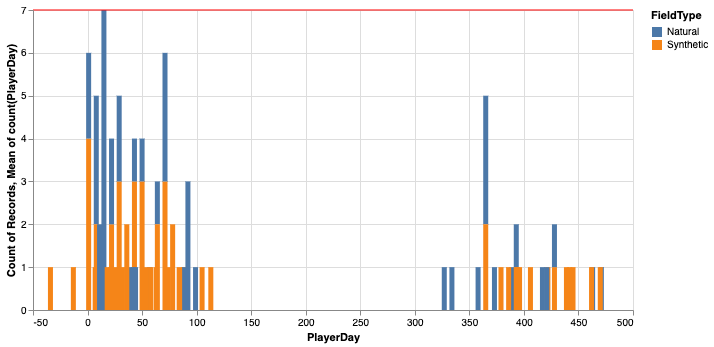

In [189]:
bar = alt.Chart(days_until_injured).mark_bar().encode(
        x='PlayerDay',
        y=alt.Y('count(PlayerDay)'),
        color='FieldType')

rule = alt.Chart(days_until_injured).mark_rule(color='red').encode(
    y='mean(count(PlayerDay)):Q'
)

(bar + rule).properties(width=600)

In [190]:
days_until_injured.loc[days_until_injured['FieldType'] == 'Natural']['PlayerDay'].median()

53.5

In [191]:
days_until_injured.loc[days_until_injured['FieldType'] == 'Synthetic']['PlayerDay'].median()

60.5

## Events they get injured on

In [194]:
days_until_injured['PlayType'].value_counts()

Rush                    41
Pass                    24
Kickoff                 23
Kickoff Not Returned     9
Kickoff Returned         4
Punt Returned            1
Extra Point              1
Punt                     1
Name: PlayType, dtype: int64

In [212]:
days_until_injured.head()

,index,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,7255,31070,31070-3,31070-3-1,Running Back,15,3,Outdoor,Natural,89,Sunny,Rush,1,RB,RB
1,9491,31933,31933-20,31933-20-1,Tight End,394,20,Indoors,Synthetic,84,Partly Cloudy,Pass,1,TE,TE
2,10679,33337,33337-2,33337-2-1,Tight End,8,2,Outdoors,Natural,83,Sunny,Rush,1,TE,TE
3,10972,33337,33337-8,33337-8-1,Tight End,365,8,Outdoors,Natural,81,Partly Cloudy,Pass,1,TE,TE
4,12160,33474,33474-19,33474-19-1,Safety,393,19,Outdoor,Natural,79,Partly Cloudy,Kickoff Not Returned,1,FS,DB


In [319]:
cross = pd.crosstab(index=days_until_injured['PlayType'],columns=days_until_injured['FieldType'],normalize='columns')

In [337]:
cross = cross.reset_index().melt(id_vars='PlayType')

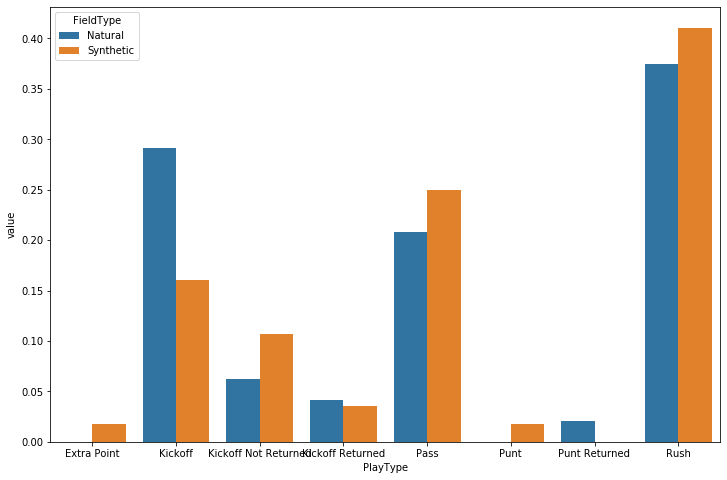

In [354]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=cross,x='PlayType',y='value',hue='FieldType')
